In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from IPython.core.display import display, HTML, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

from collections import defaultdict
import sys
sys.path.insert(1, '../scripts/')
import eda_tools as et
import data_munging_tools as dmt
import model_fitting_tools as mft


## Load data

In [2]:
# `pd.read_html()`  requires packages: lxml, html5lib, beautifulsoup4
data_dict = (pd.read_html('../data/AttributeDescriptions.html')[0]
             .copy()
             .rename(columns=lambda x: x.lower().replace(" ", "_"))
             .assign(field_name=lambda x: x["field_name"].apply(lambda x: x.lower()))
             .set_index("field_name")
             .sort_index()
            )

In [3]:
display(Markdown("### Data Dict"))
data_dict.style.set_properties(subset=['description'], **{'width': '700px'})

### Data Dict

,category,description
field_name,,
api,Identifier,Globally unique identifier for the well
bakken_isopach_ft,Geology,Thickness of the oil producing Bakken formation at the latitude/longitude of the well
bh_lat,Location,Latitude of the 'bottom hole' (the end of the laterally drilled bore)
bh_lng,Location,Longitude of the 'bottom hole' (the end of the laterally drilled bore)
choke_size,nan,Diameter in inches of the mechanical flow limiter
countyname,Location,Name of the County where the well is located
currentoperator,nan,Name of the Company that operates the well
currentwellname,nan,"Name of the well; essentially free text, naming conventions vary by operator"
dfelev,nan,Drilling floor elevation


In [4]:
# Load the dataframes
test_df = pd.read_csv('../data/cleaned-input.test.tsv', sep='\t', low_memory=False)
train_df = pd.read_csv('../data/cleaned-input.training.tsv', sep='\t', low_memory=False)

In [5]:
inspect_df = (train_df.copy()
                      .rename(columns=str.lower)
                      .assign(api = lambda x: x["api"].str.strip("US"))
                      .set_index("api")
                      .sort_index(axis=1)
                      .assign(length=lambda x: dmt.haversine_distance(x["surface_lat"], x["surface_lng"], x["bh_lat"], x["bh_lng"]),
                              prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                              fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                              stage_spacing=lambda x: x["total_num_stages"] / x["length"],
                              choke_size=lambda x: x["choke_size"].apply(lambda x: dmt.parse_choke_size(x))
                             )
             )

# Categorical Columns

In [6]:
cat_df = inspect_df.copy().select_dtypes("O")

In [7]:
for col in cat_df.columns:
    nunique = cat_df[col].nunique()
    
    if nunique <= 20:
        display(Markdown(f"### {col}: {nunique}"))
        display(cat_df[col].value_counts().to_frame())
    else:
        display(Markdown(f"### {col}: **{nunique}**"))

### countyname: 15

,countyname
MCKENZIE,1796
MOUNTRAIL,1605
WILLIAMS,1081
DUNN,1078
DIVIDE,432
BURKE,182
STARK,133
BILLINGS,101
BOTTINEAU,81
MCLEAN,25


### currentoperator: **56**

### currentwellname: **6529**

### fieldname: **333**

### footages: **6120**

### leasename: **3231**

### leasenumber: **4523**

### originaloperator: **99**

### originalwellname: **6527**

### producedpools: 13

,producedpools
BAKKEN,6310
SANISH,82
SPEARFISH,72
BAKKEN/THREE FORKS,30
SPEARFISH/MADISON,8
MADISON,6
LODGEPOLE,2
TYLER,2
THREE FORKS,2
"BAKKEN,WINNIPEGOSIS",1


### qq: **43**

### range: **24**

### spud_date: **2133**

### stimulated_formation: 14

,stimulated_formation
bakken,3987
three forks,1617
spearfish,85
pronghorn,7
madison,4
tyler,3
"bakken,three forks",2
red river,2
nesson,1
scallion,1


### township: **30**

### type_treatment: 9

,type_treatment
sand frac,4618
other,622
fracture,158
"other,sand frac",3
acid,2
hydrochloric acid,1
"acid,gelled acid",1
"hydrochloric acid,sand frac",1
"fracture,sand frac",1


### well_status_date: **2151**

### wellbore: 3

,wellbore
HORIZONTAL,6519
HORIZONTAL RE-ENTRY,6
DIRECTIONAL,4


### wellstatus: 8

,wellstatus
A,6248
IA,250
DRL,7
TA,7
PA,7
AB,5
DRY,3
PNC,2


### welltype: 1

,welltype
OG,6529


### Plots

In [9]:
cat_df = (inspect_df.copy()
                  .select_dtypes("O")
                  .pipe(dmt.drop_hi_lo_card)
                  .pipe(dmt.reduce_cardinality)
         )

Shape before cardinality removal: (6529, 20)
Shape after cardinality removal: (6529, 12)


In [10]:
cat_cols = cat_df.columns

In [11]:
target_col = "production_liquid_180"

In [12]:
cat_df = cat_df.join(inspect_df.filter([target_col]))

In [13]:
def inspect_cat_plots(df, cat_col, target_col):
    """
    Pass a dataframe, a categorical feature, and the (continuous) target

    Returns a two barcharts for each categorical feature:
     1. a count of the number of unique values in that column
     2. the median score of the target column fo each unique value in that column.
     """
    sub_df = df.filter([cat_col, target_col])
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    sns.countplot(data=sub_df, x=cat_col, ax=ax[0])
    
    for item in ax[0].get_xticklabels() + ax[1].get_xticklabels():
        item.set_rotation(45)
    
    sns.boxplot(data=sub_df, x=cat_col, y=target_col, ax=ax[1])


In [14]:
cat_cols

Index(['countyname', 'currentoperator', 'fieldname', 'originaloperator',
       'producedpools', 'qq', 'range', 'stimulated_formation', 'township',
       'type_treatment', 'wellbore', 'wellstatus'],
      dtype='object')

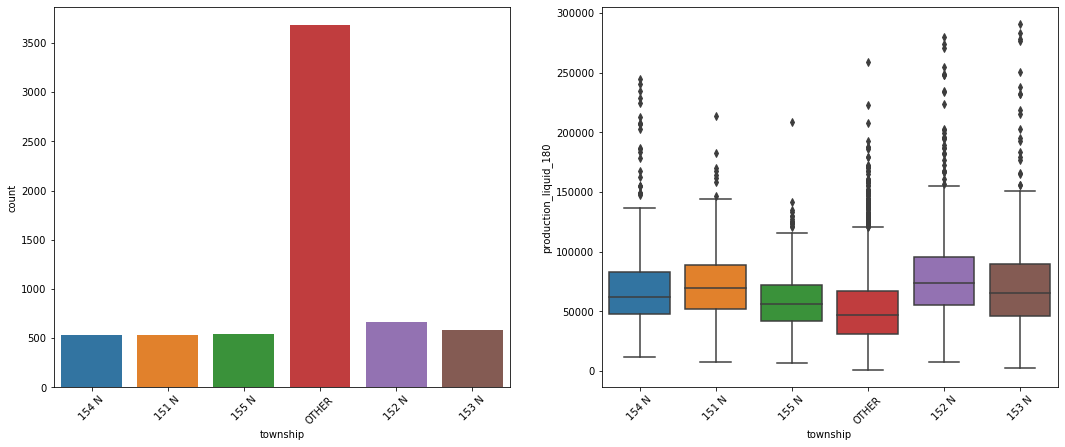

In [15]:
inspect_cat_plots(cat_df, "township", target_col)

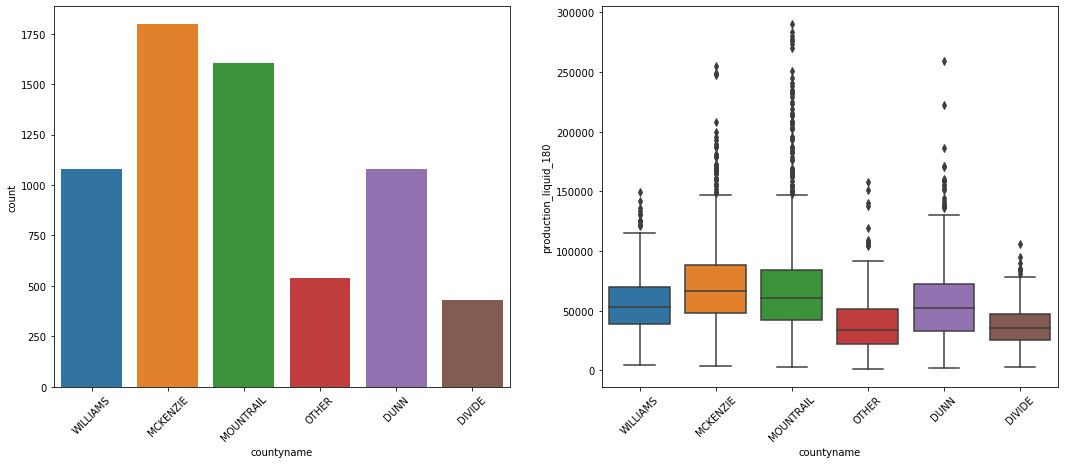

In [16]:
inspect_cat_plots(cat_df, "countyname", target_col)

# Continuous Features

In [17]:
foi = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
'legs',
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing', 
'choke_size_new',
'mean_tvd',
'bakken_isopach_ft',
'choke_size'
])

total_cols = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
])

normd_cols = sorted([
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing'
])

other = sorted([
'mean_tvd',
'bakken_isopach_ft' 
])

In [18]:
cont_df = (inspect_df.copy()
                   .select_dtypes("number")
                   .filter(foi)
                   .sort_index(axis=1)
          )

In [19]:
cont_df.shape

(6529, 11)

In [20]:
cont_df.columns

Index(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs', 'length',
       'mean_tvd', 'prop_per_ft', 'stage_spacing', 'total_lbs_proppant',
       'total_num_stages', 'total_volume_bbls'],
      dtype='object')

## Setting outliers to NaN

#### ... Before scrubbing outliers

In [21]:
def make_strip_plots(df, col, lims_dict):
    lims = lims_dict[col]
    sub_df = df.filter([col])
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    sns.stripplot(data=sub_df, x=col, ax=ax[0])
    
    print(lims)
    
    if lims["max"] < float("inf"):
        upper = lims["max"]
        ax[0].axvline(upper, color="r")
        before_filter = sub_df.shape[0]
        queried_df = sub_df.query(f"{col} < @upper")
        after_filter = queried_df.shape[0]
        print(before_filter - after_filter)
        sns.stripplot(data=queried_df, x=col, ax=ax[1])
        
    if lims["min"] > 0:
        lower = lims["min"]
        ax[0].axvline(lower, color="r")
        before_filter = sub_df.shape[0]
        queried_df = sub_df.query(f"{col} > @lower")
        after_filter = queried_df.shape[0]
        print(before_filter - after_filter)
        sns.stripplot(data=queried_df, x=col, ax=ax[1])

In [22]:
thresh_dict = defaultdict(lambda: {"min": 0, "max": float("inf")})
thresh_dict["total_lbs_proppant"]["max"] = 20000000.0
thresh_dict["total_volume_bbls"]["max"] = 500000.0
thresh_dict["length"]["min"] = 2000
thresh_dict["mean_tvd"]["min"] = 4000
thresh_dict["total_num_stages"]["min"] = 5

{'min': 0, 'max': 500000.0}
987


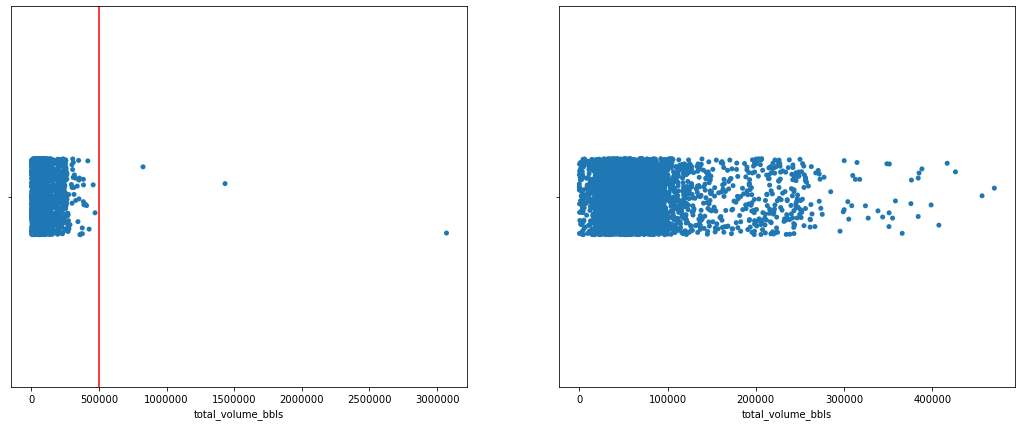

In [23]:
make_strip_plots(cont_df, "total_volume_bbls", thresh_dict)

{'min': 4000, 'max': inf}
407


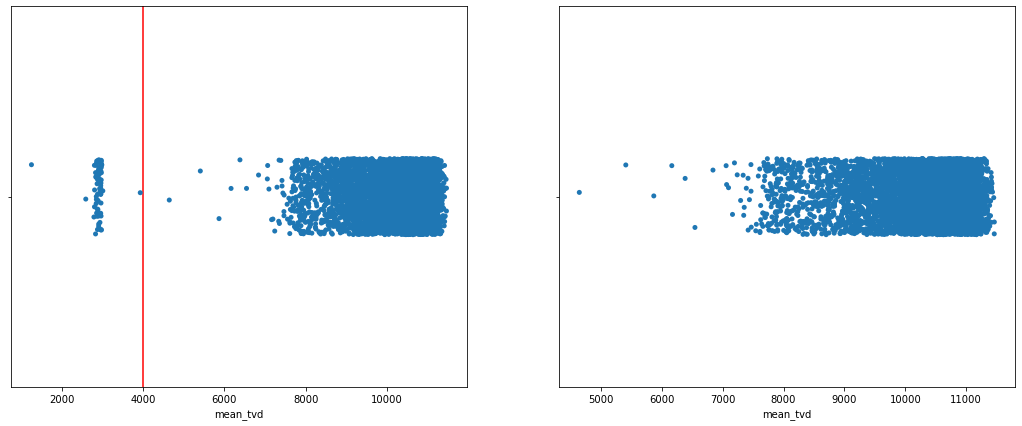

In [24]:
make_strip_plots(cont_df, "mean_tvd", thresh_dict)

{'min': 5, 'max': inf}
601


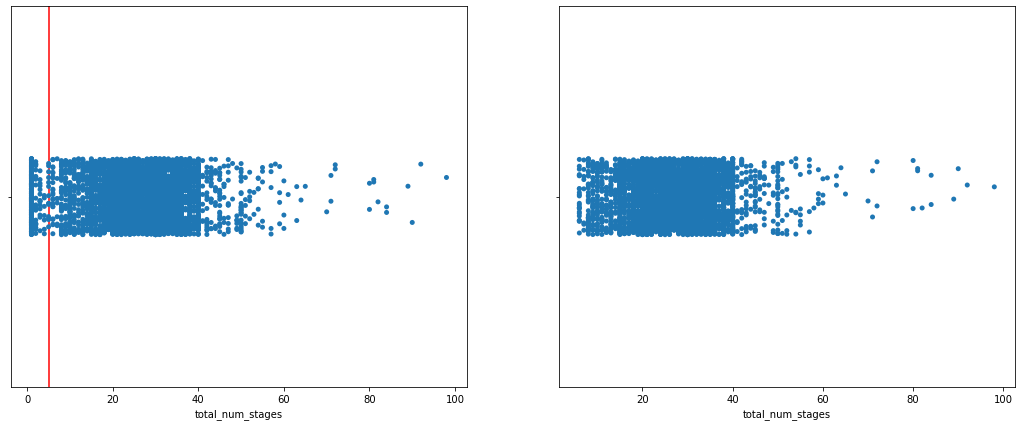

In [25]:
make_strip_plots(cont_df, "total_num_stages", thresh_dict)

In [26]:
def remove_outiers(df, lims_dict):
    df = df.copy()
    for feature, limits in lims_dict.items():
        print(feature)
        up_lim = limits["max"]
        lo_lim = limits["min"]
        
        max_mask = df[feature] > up_lim
        min_mask = df[feature] < lo_lim
        
        both_mask = min_mask | max_mask
                
        df.loc[both_mask, feature] = np.nan 
    return df

In [27]:
clean_df = (cont_df.copy()
                   .pipe(remove_outiers, thresh_dict)
                    .assign(prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                            fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                            stage_spacing=lambda x: x["total_num_stages"] / x["length"]
                            )
           )

total_lbs_proppant
total_volume_bbls
length
mean_tvd
total_num_stages


#### After scrubbing outliers:

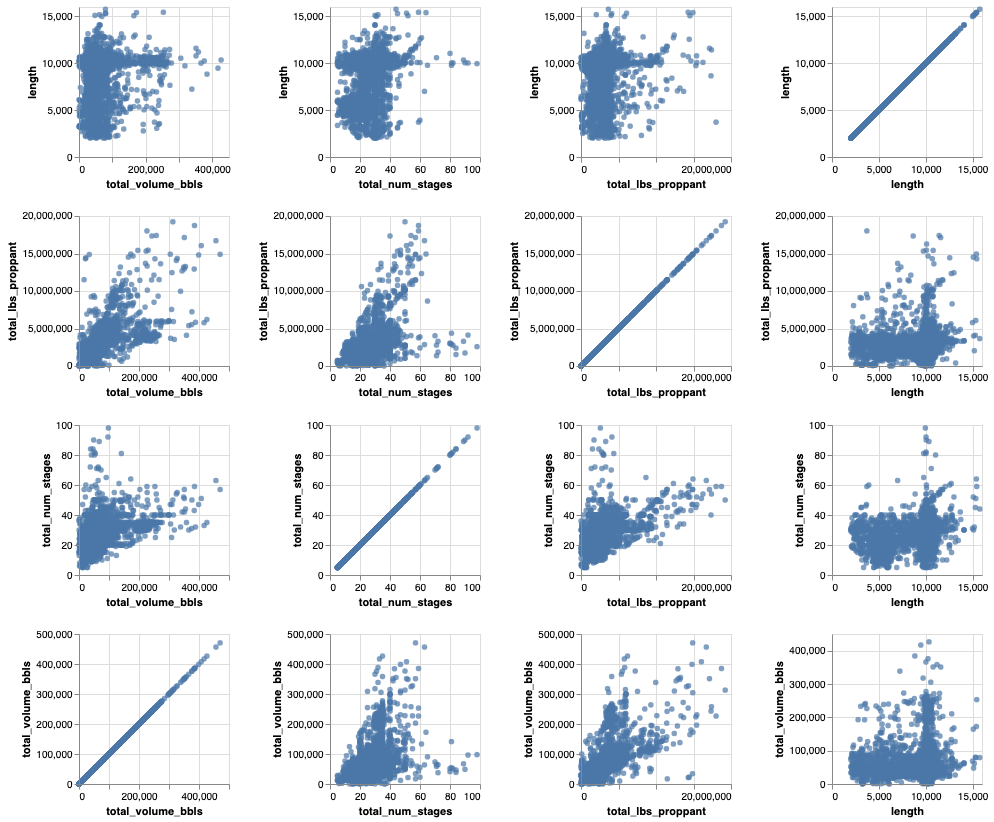

In [28]:
alt.Chart(clean_df[total_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=total_cols,
    column=total_cols[::-1]
)

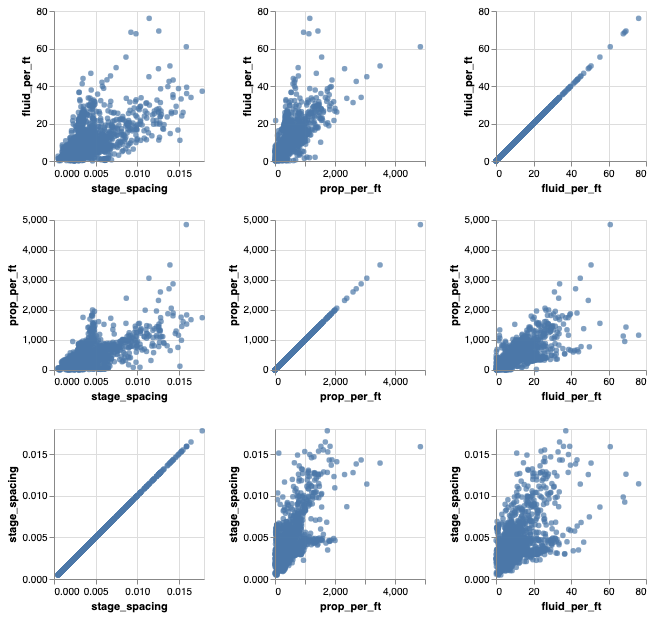

In [29]:
alt.Chart(clean_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=normd_cols,
    column=normd_cols[::-1]
)

### TODO: 
#### Calculate distance to nearest neighbor

## Correlation Matrix Heatmap

In [30]:
corr_df = clean_df.corr().round(3)

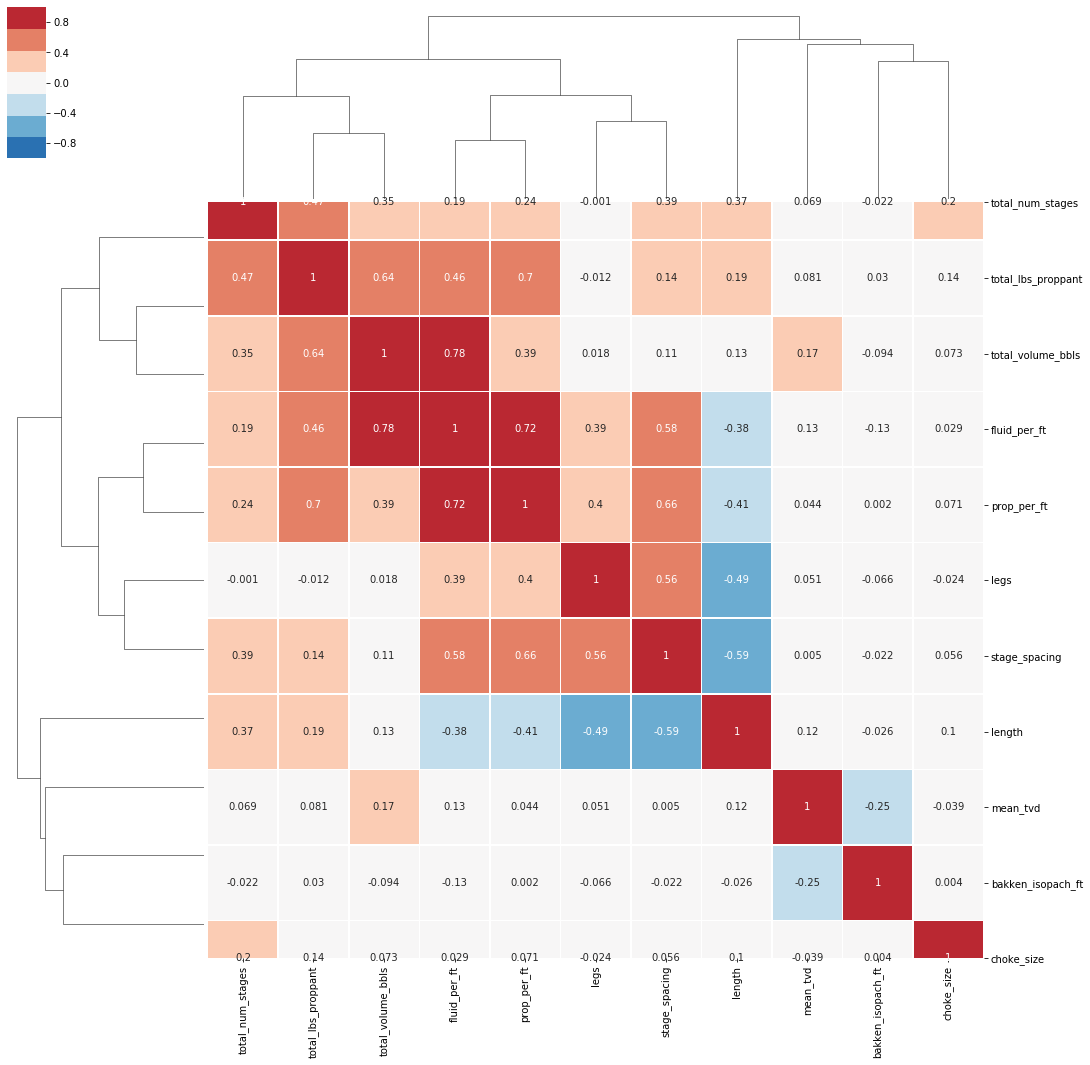

In [31]:
# fig, ax = plt.subplots(figsize=(10,10)) 
sns.clustermap(data=corr_df, 
                    cmap=sns.color_palette("RdBu_r", 7), 
                    linewidths=.5, 
                    vmin=-1, vmax=1, 
                    annot=True)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.75)  # scale current size by 1.5

# Production Data

In [32]:
inspect_df.query("production_liquid_90 > 0").shape

(6396, 56)

In [33]:
prod_df = (inspect_df.copy()
                   .filter(regex="production_liquid")
                   .query("production_liquid_30 > 0")
                   .rename(columns=lambda x: int(x.split("_")[-1]))
                   .drop([1825], axis=1)
                   .reset_index()
                   .melt(id_vars="api", value_name="cum_prod", var_name="ip_day")
                   .sort_values(["api", "ip_day"])
                   .reset_index(drop=True)
                   .assign(
                           ip_day=lambda x: x["ip_day"].astype(int),
                           cum_prod=lambda x: x["cum_prod"].astype(float),
                           day_diff=lambda x: x.groupby(["api"])["ip_day"].transform(pd.Series.diff),
                           prod_diff=lambda x: x.groupby(["api"])["cum_prod"].transform(pd.Series.diff),
                           prod_rate = lambda x: (x["prod_diff"] / x["day_diff"]).round(2)
                          )     
          )

In [34]:
prod_df.head()

,api,ip_day,cum_prod,day_diff,prod_diff,prod_rate
0,33007015740000,30,4829.0,NaN,NaN,NaN
1,33007015740000,60,9223.0,30.0,4394.0,146.47
2,33007015740000,90,12745.0,30.0,3522.0,117.40
3,33007015740000,120,15051.0,30.0,2306.0,76.87
4,33007015740000,150,15975.0,30.0,924.0,30.80


In [36]:
well_ids = inspect_df.index.to_list()
well_ids[:10]

['33105034550000',
 '33053034020000',
 '33061026020000',
 '33089007540000',
 '33061021060000',
 '33025014870000',
 '33053031590000',
 '33105027640000',
 '33053033000000',
 '33061009490000']

In [37]:
def plot_well_curve(prod_df, well_id):
    sub_df = prod_df.query("api == @well_id")
    display(Markdown(f"## {well_id}"))
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(sub_df["ip_day"], sub_df["cum_prod"])
    ax[1].plot(sub_df["ip_day"], sub_df["prod_rate"])
    plt.show()
    display(sub_df)

## 33013014020000

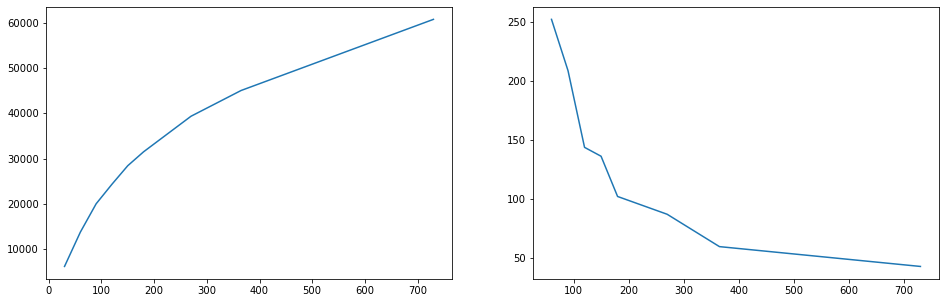

,api,ip_day,cum_prod,day_diff,prod_diff,prod_rate
945,33013014020000,30,6185.0,NaN,NaN,NaN
946,33013014020000,60,13754.0,30.0,7569.0,252.30
947,33013014020000,90,20019.0,30.0,6265.0,208.83
948,33013014020000,120,24336.0,30.0,4317.0,143.90
949,33013014020000,150,28427.0,30.0,4091.0,136.37
950,33013014020000,180,31496.0,30.0,3069.0,102.30
951,33013014020000,270,39348.0,90.0,7852.0,87.24
952,33013014020000,365,45032.0,95.0,5684.0,59.83
953,33013014020000,730,60740.0,365.0,15708.0,43.04


In [38]:
well_oi = well_ids[700]
plot_well_curve(prod_df, well_oi)

## 33025012450000

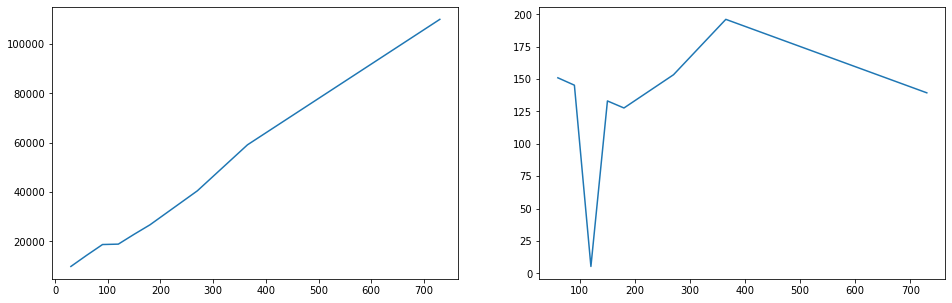

,api,ip_day,cum_prod,day_diff,prod_diff,prod_rate
9702,33025012450000,30,9813.0,NaN,NaN,NaN
9703,33025012450000,60,14343.0,30.0,4530.0,151.00
9704,33025012450000,90,18702.0,30.0,4359.0,145.30
9705,33025012450000,120,18862.0,30.0,160.0,5.33
9706,33025012450000,150,22856.0,30.0,3994.0,133.13
9707,33025012450000,180,26687.0,30.0,3831.0,127.70
9708,33025012450000,270,40490.0,90.0,13803.0,153.37
9709,33025012450000,365,59123.0,95.0,18633.0,196.14
9710,33025012450000,730,110007.0,365.0,50884.0,139.41


In [39]:
well_oi = well_ids[500]
plot_well_curve(prod_df, well_oi)

### TODO: 
#### Detect anomalies and impute production
#### Look at date

## Preliminary model fitting

In [40]:
target = "production_liquid_180"

In [41]:
def fill_median(df, cols=None):
    df = df.copy()
    
    if cols == None:
        cols = df.columns
    for col in cols:
        fill_value = df[col].median()
        df[col].fillna(value=fill_value, inplace=True)
        
    return df

In [42]:
full_df = (clean_df.copy()
               .join(inspect_df.filter([target]))
               .dropna(subset=[target])
               .pipe(fill_median)
               
          )

In [43]:
test, train = train_test_split(full_df)
train_X, train_y = mft.X_y_split(test, target=target)
test_X, test_y = mft.X_y_split(test, target=target)

In [44]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=500, 
                                subsample = .7, 
                                max_depth =7, 
                                min_samples_split= 3, 
                                random_state=1984)

In [45]:
gbr.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=1984, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Error metrics

In [46]:
 mse, mae, rmse, rrse = mft.eval_model(gbr, test_X, test_y, train_y)

y_hat = gbr.predict(test_X)

eval_df = (pd.concat([test_y.reset_index(), pd.Series(y_hat, name="pred").round(2)], axis=1)
           .set_index("api")
           .rename(columns={"production_liquid_180": "actual"})
           .assign(resid=lambda x: x["pred"] - x["actual"])
           .assign(perc_resid=lambda x: x["resid"] / x["actual"] * 100)
           .assign(abs_resid=lambda x: x["resid"].abs())
           .assign(abs_perc_resid=lambda x: x["abs_resid"] / x["actual"] * 100)
          )

mape = eval_df.abs_perc_resid.mean()

mape_adj = eval_df.abs_resid.mean() / eval_df.actual.mean() * 100

In [47]:
error_dict = {"mae ": mae, "rmse": rmse, "rrse": rrse, "mae": mae, "mape": mape, "adj_mape": mape_adj}

In [48]:
for name, val in error_dict.items():
    print(name, val.round())

mae  14205.0
rmse 18946.0
rrse 56.0
mae 14205.0
mape 35.0
adj_mape 23.0


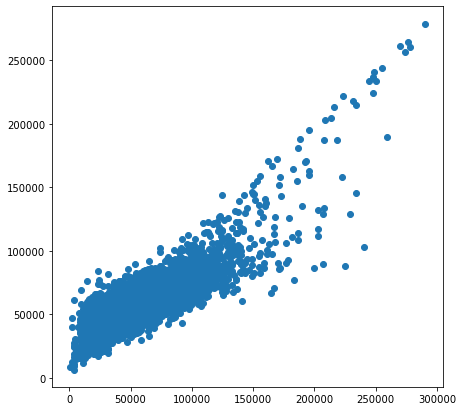

In [49]:
plt.subplots(figsize=(7, 7))
plt.scatter(data=eval_df, x="actual", y="pred")

### The model is clearly biased: it's overpredicting small values and underpredicting large values

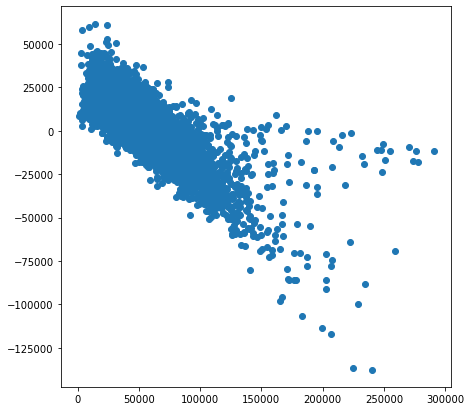

In [50]:
plt.subplots(figsize=(7, 7))
plt.scatter(data=eval_df, x="actual", y="resid")

In [51]:
train_X.columns.values

array(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs',
       'length', 'mean_tvd', 'prop_per_ft', 'stage_spacing',
       'total_lbs_proppant', 'total_num_stages', 'total_volume_bbls'],
      dtype=object)

In [52]:
feat_imp_df = mft.get_rig_df(gbr, train_X.columns.values)

### Feature Importances

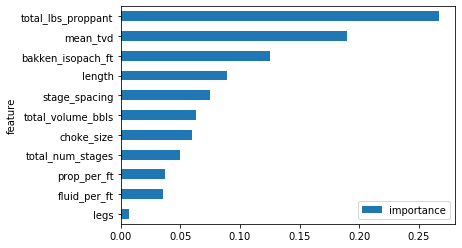

In [53]:
display(Markdown("### Feature Importances"))
feat_imp_df.plot.barh()